In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
# Define the column names since the file doesn't have a header
column_names = ["target", "id", "date", "flag", "user", "text"]

# Read input data
tweets = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', names=column_names, header=None)

# Drop 'flag' as it won't be of use
tweets = tweets.drop(['flag'], axis=1)

# Remove the timezone abbreviation (PDT) from the 'date' column as all are PDT
tweets['date'] = tweets['date'].str.replace('PDT', '')

# Convert the 'date' column to datetime format
tweets['date'] = pd.to_datetime(tweets['date'], format='%a %b %d %H:%M:%S %Y')

# Define the desired subset size (e.g., 20% of the original data)
subset_size = int(0.5 * len(tweets))  # Adjust as needed

# Randomly sample the subset
tweets = tweets.sample(n=subset_size, random_state=42)

tweets

,target,id,date,user,text
541200,0,2200003196,2009-06-16 18:18:12,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,2009-04-06 23:11:14,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,2009-06-23 13:40:11,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,2009-06-01 10:26:07,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,2009-06-20 12:56:51,yogicerdito,upper airways problem
...,...,...,...,...,...
953018,4,1824563004,2009-05-17 01:55:54,snedwan,@Yorksville no I'm seeing them at Hampden in G...
993770,4,1835439669,2009-05-18 05:59:58,beeveekay,Brr- it's 61 in San antonio in May
937940,4,1793332552,2009-05-14 02:16:55,joshh01,@craiggower i know this sounds random: i'm ver...
208691,0,1973785775,2009-05-30 11:49:53,A1nz,@Stephaniekaren wants to leave me for this dude.


In [3]:
# Tokenize the text into smaller parts

tweet = tweets.text.values
tokenizer = Tokenizer(num_words=5000)

# Association between words and assigned number

tokenizer.fit_on_texts(tweet) 

In [4]:
# Replace the words with their assigned numbers

encoded_docs = tokenizer.texts_to_sequences(tweet)

# Pad sentences to have equal length

padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [5]:
# Using Long Short Term Memory Networks to work with words in large texts
# This uses dropout to drop some neurons and avoid overfitting

vocab_size = len(tokenizer.word_index) + 1
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           13826528  
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 32)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 13843179 (52.81 MB)
Trainable params: 13843179 (52.81 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [6]:
# Training

history = model.fit(padded_sequence, tweets['target'], validation_split=.9, epochs=3, batch_size=32, shuffle=True)

Epoch 1/3
2500/2500 [==============================] - 594s 237ms/step - loss: -68.9969 - accuracy: 1.3750e-04 - val_loss: -127.6614 - val_accuracy: 0.0000e+00
Epoch 2/3
2500/2500 [==============================] - 592s 237ms/step - loss: -185.9409 - accuracy: 0.0000e+00 - val_loss: -243.3843 - val_accuracy: 0.0000e+00
Epoch 3/3
2500/2500 [==============================] - 622s 249ms/step - loss: -317.4928 - accuracy: 0.0200 - val_loss: -399.5653 - val_accuracy: 0.0600


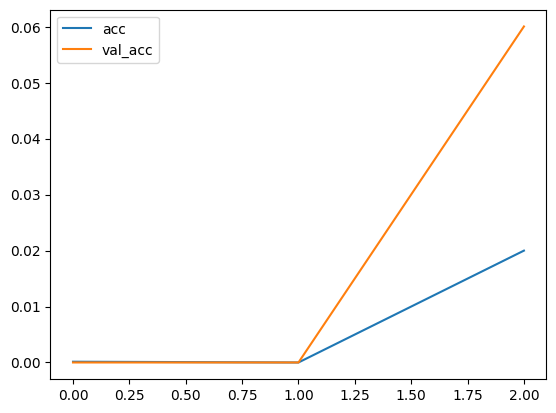

In [7]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()